# Decision trees

**The prediction task**: 
To predict which movies will be highly rated by users (movie watchers).

**The rationale**: 
Identify movies that can be recommended by a movie streaming service when no data about the user is available (the so-called “cold start” problem)

**Type of task**: 
Binary classification 

**Algorithm to be used**: 
CART (Classification and Regression Trees) 

### Load the required libraries

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix

### Load and examine the data

The data originates from the [Movie Industry dataset](https://www.kaggle.com/datasets/danielgrijalvas/movies), where further information about it can be found (including the description of all the variables). 
Note: the original data set has been adapted for this class.

In [2]:
movies = pd.read_csv(Path.cwd().parent / 'data' / 'movies.csv')
movies.head(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146
1,The Blue Lagoon,R,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98
5,Friday the 13th,R,Horror,1980,6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95
6,The Blues Brothers,R,Action,1980,7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,27000000.0,115229890.0,Universal Pictures,133
7,Raging Bull,R,Biography,1980,8.2,330000.0,Martin Scorsese,Jake LaMotta,Robert De Niro,United States,18000000.0,23402427.0,Chartoff-Winkler Productions,129
8,Superman II,PG,Action,1980,6.8,101000.0,Richard Lester,Jerry Siegel,Gene Hackman,United States,54000000.0,108185706.0,Dovemead Films,127
9,The Long Riders,R,Biography,1980,7.0,10000.0,Walter Hill,Bill Bryden,David Carradine,United States,10000000.0,15795189.0,United Artists,100


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5235 entries, 0 to 5234
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      5235 non-null   object 
 1   rating    5235 non-null   object 
 2   genre     5235 non-null   object 
 3   year      5235 non-null   int64  
 4   score     5235 non-null   float64
 5   votes     5235 non-null   float64
 6   director  5235 non-null   object 
 7   writer    5235 non-null   object 
 8   star      5235 non-null   object 
 9   country   5235 non-null   object 
 10  budget    5235 non-null   float64
 11  gross     5235 non-null   float64
 12  company   5233 non-null   object 
 13  runtime   5235 non-null   int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 572.7+ KB


We will create the outcome variable - `high_score` - based on the `score` variable. A movie is considered to have high score, if its score is above the 3rd quartile (75th percentile)

In [4]:
score_75th_perc = np.percentile(movies.score, 75)

high_score = movies.score.apply(lambda sc: 1 if sc > score_75th_perc else 0)
high_score = pd.Series(high_score)
high_score.value_counts(normalize=True)

score
0    0.754537
1    0.245463
Name: proportion, dtype: float64

We will remove from the data set the variable used for creating the outcome variable. This is not strictly required, but it is better to do so, to avoid potential, unintentional use of that variable for building a model. The reason we do not want to use it for model building is that, by being the source of the outcome variable, it completely determines that variable and its use would be a kind of “cheating”.

In [5]:
movies.drop(columns='score', inplace=True)

### Data preparation

Character variables cannot be directly used for building predictive models. If considered potentially relevant for the prediction task, they need to be transformed to be used for model building. 
In scikit-learn, this transformation can be done in one of the following two ways, depending on the type of the character variable:

*  If the variable is *ordinal* in nature, that is, its values have a natural order or ranking, then [**Label encoding**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) is used. An example of an ordinal variable is medal, with potential values of 'bronze', 'silver', and 'gold'; or school grades, from 'unsatisfactory' to 'excellent'. Label encoding involves assigning a sequence of consecutive integer values (e.g., 1,2,3) to the unique variable values ('bronze', 'silver', 'gold', respectively).  
   
* If the variable is a *categorical* variable, with no order / ranking present among its values, [**One-Hot Encoding**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is used. Examples of such variables are color, material, gender, nationality, etc. A nice explanation of One-Hot Encoding is given in [this article](https://www.geeksforgeeks.org/passing-categorical-data-to-sklearn-decision-tree/): "Imagine you have a list of fruits: apples, bananas, and oranges. Now, One-Hot Encoding is like making a checklist for each fruit. If an apple is on the list, you put a check in the “apple” column and leave the others blank. If it’s a banana, you check the “banana” column, and so on. So, ... we create separate columns for each fruit. If the fruit is there, the column gets a check (1); if not, it stays blank (0)." See an example [here](https://www.geeksforgeeks.org/ml-one-hot-encoding/)

Let's examine the character variables in the dataset. In pandas, these are variables of the "object" type

In [6]:
movies.select_dtypes(include=object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5235 entries, 0 to 5234
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      5235 non-null   object
 1   rating    5235 non-null   object
 2   genre     5235 non-null   object
 3   director  5235 non-null   object
 4   writer    5235 non-null   object
 5   star      5235 non-null   object
 6   country   5235 non-null   object
 7   company   5233 non-null   object
dtypes: object(8)
memory usage: 327.3+ KB


In dealing with character variables, we start with the `name` variable. It is irrelevant for the prediction and thus will be removed. 
The other character variables will be examined in terms of their type (ordinal or categorical), number of distinct values, and value distribution to determine if it would make sense to transform them and include in the model.

First, exclude the `name` variable and then examine the other character variables

In [7]:
movies.drop(columns='name', inplace=True)

In [8]:
char_vars = movies.select_dtypes(include=object).columns.tolist()
for char_var in char_vars:
    print(f"{char_var}: {movies[char_var].nunique()}")

rating: 3
genre: 9
director: 1986
writer: 3100
star: 1745
country: 5
company: 1405


Variables `director`, `writer`, `star` and `company` have too many distinct values, which make them unsuitable for transformation through OneHot encoding. Thus, we will drop them, as well 

In [9]:
movies.drop(columns=['director', 'writer', 'star', 'company'], inplace=True)

Examine the distribution of the remaining three string variables:

In [10]:
movies.rating.value_counts()

rating
R        2597
PG-13    1729
PG        909
Name: count, dtype: int64

In [11]:
movies.genre.value_counts()

genre
Comedy       1469
Action       1409
Drama         830
Crime         388
Adventure     313
Biography     308
Horror        245
Animation     194
Other          79
Name: count, dtype: int64

Considering that Animation and Horror are far less present in the data than other genres, it might be better to include them into the Other category:  

In [12]:
movies['genre'] = movies.genre.apply(lambda g: 'Other' if g in ['Horror', 'Animation'] else g)
movies.genre.value_counts()

genre
Comedy       1469
Action       1409
Drama         830
Other         518
Crime         388
Adventure     313
Biography     308
Name: count, dtype: int64

In [13]:
movies.country.value_counts()

country
United States     4211
United Kingdom     470
Other              354
Canada             102
France              98
Name: count, dtype: int64

We might also consider including France and Canada in the Other group. We keep as is for now. You may try to do it on your own and see if / how that would affect the model performance.

Variables `rating`, `genre`, and `country` have fairly small number of distinct values and thus can be transformed and used for model building. 
All three are true categorical variable and will be transformed using OneHotEncoder:

In [14]:
onehot_encoder = OneHotEncoder(sparse_output=False, # do not return result as a sparse matrix
                               drop='first')  # 'first' to drop the first category to avoid multicollinearity
onehot_encoded = onehot_encoder.fit_transform(movies[['rating', 'genre', 'country']])
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(['rating', 'genre', 'country']))

In [15]:
onehot_encoded_df.head(10)

,rating_PG-13,rating_R,genre_Adventure,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Other,country_France,country_Other,country_United Kingdom,country_United States
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
# drop the rating, genre and country and replace them with the onehot encoded representation of their values 
movies.drop(columns=['rating', 'genre', 'country'], inplace=True)
movies = pd.concat([movies, onehot_encoded_df], axis=1)

In [17]:
movies.head(10)

,year,votes,budget,gross,runtime,rating_PG-13,rating_R,genre_Adventure,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Other,country_France,country_Other,country_United Kingdom,country_United States
0,1980,927000.0,19000000.0,46998772.0,146,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1980,65000.0,4500000.0,58853106.0,104,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1980,1200000.0,18000000.0,538375067.0,124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1980,221000.0,3500000.0,83453539.0,88,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1980,108000.0,6000000.0,39846344.0,98,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1980,123000.0,550000.0,39754601.0,95,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,1980,188000.0,27000000.0,115229890.0,133,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1980,330000.0,18000000.0,23402427.0,129,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1980,101000.0,54000000.0,108185706.0,127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1980,10000.0,10000000.0,15795189.0,100,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can now proceed to splitting the data into training and test sets and building models.

### Train-test split

We split the data into training and test sets in the same way we did before (random stratified split), using 80% of the data for the training set.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(movies,
                                                    high_score,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True,
                                                    stratify=high_score)

Check that the distribution of the outcome variable in the train and test sets is the same:

In [19]:
y_train.value_counts(normalize=True)

score
0    0.754537
1    0.245463
Name: proportion, dtype: float64

In [20]:
y_test.value_counts(normalize=True)

score
0    0.754537
1    0.245463
Name: proportion, dtype: float64

### Initial (default) decision tree model

We will build the first model by setting only a minimum number of hyperparameters of the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), and using default values of the remaining ones

In [21]:
tree1 = DecisionTreeClassifier(random_state=1,
                               class_weight='balanced', #this is due to the imbalanced dataset
                               min_impurity_decrease=0.01) #this is to prevent growing an overly large tree
tree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.01,
                       random_state=1)

The `class_weight` hyperparamter allows for neutralising the effect of class imbalance by using weights that are inversely proportional to class frequencies in the input data.

Plot the model:

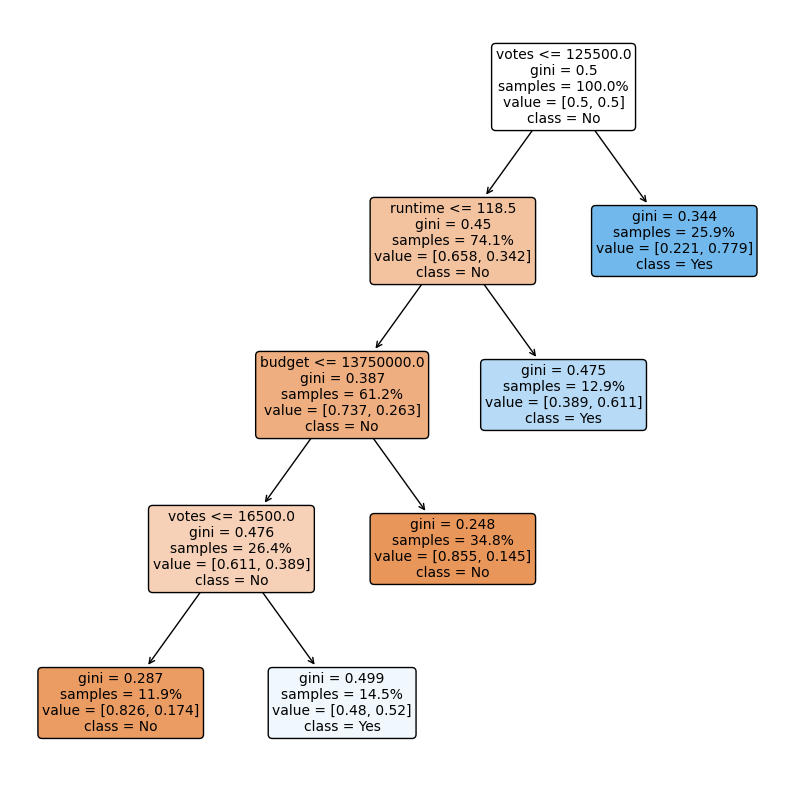

In [22]:
feature_names = X_train.columns.tolist()

_, ax = plt.subplots(figsize=(10,10))
plot_tree(tree1,
          feature_names=feature_names,
          class_names=['No', 'Yes'],
          proportion=True,
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax);

In the tree, the `value` label in each node denotes the proportion of observations reaching that node for each class (= value of the outcome variable). Note that `value[0] + value[1] = 1`. For example, in the above tree, the first leaf node (the one on the left)  has `value = [0.826, 0.174]`, indicating that 82.6% of samples are of class 'No', while 17.4% of samples are of class "Yes".

Detailed explanation of the tree visualisation is given in [this tree plotting example](https://scikit-learn.org/1.5/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py) of the sklearn documentation.

Make predictions on the test data set and then compute and plot the confusion matrix

In [23]:
tree1_pred = tree1.predict(X_test)

In [24]:
tree1_pred[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

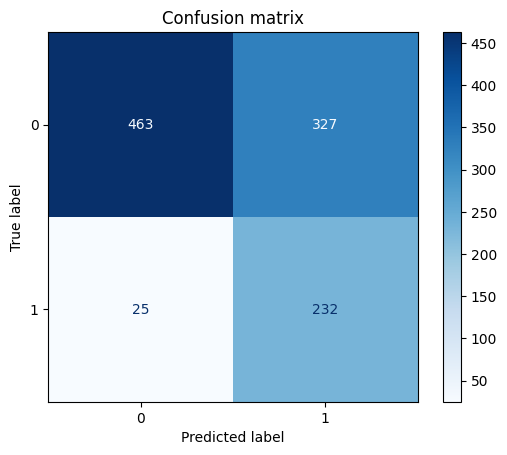

In [25]:
cm1 = confusion_matrix(y_test, tree1_pred)

from classification_util import plot_confusion_matrix
plot_confusion_matrix(cm1, tree1.classes_)

Interpretation of the confusion matrix:

TP = 232 - there are 232 movies that we predicted as having high score and they really did receive high scores from the audience

TN = 463 - there are 463 movies for which we correctly predicted that they will not receive high score

FP = 327 - for 327 movies, we wrongly predicted that they will receive high score by the public

FN = 25 - we missed to identify 25 movies as having high score; that is, for 25 movies we incorrectly predicted that they will not receive high score<\b>

Now, we will use the confusion matrix to compute a set of standard evaluation measures

In [26]:
# Accuracy
tree1_accuracy = (cm1[0,0] + cm1[1,1])/cm1.sum()
print(f"{tree1_accuracy:.4f}")

0.6638


Interpretation: Out of all the movies in the test data set, we have correctly predicted if a movie will have high score or not for 66.38% of the movies

In [27]:
# Precision
tree1_precision = cm1[1,1] / cm1[:,1].sum()
print(f"{tree1_precision:.4f}")

0.4150


Interpretation: Out of all the movies that were predicted to have high score, 41.5% of movies really have high score

In [28]:
# Recall 
tree1_recall = cm1[1,1] / cm1[1,:].sum()
print(f"{tree1_recall:.4f}")

0.9027


Interpretation: Out of all the movies that received high score, 90.27% were predicted to have high score.

In [29]:
# F1

tree1_F1 = 2*(tree1_precision * tree1_recall)/(tree1_precision + tree1_recall)
print(f"{tree1_F1:.4f}")

0.5686


Interpretation: When precision and recall are balanced, the overall model performance is 56.86%, indicating that we are not doing that good job of classifying movies into those that will score high and those that will not.

Let’s now put the computation of all the measures in a function, so that we can easily compute and then compare evaluation measures for different models

In [30]:
def compute_basic_eval_measures(cm, model_name=""):

    from pandas import Series

    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]

    accuracy = (TP + TN)/cm.sum()
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    F1 = 2*precision*recall/(precision + recall)

    return Series(data=[accuracy, precision, recall, F1],
                  index=['accuracy', 'precision', 'recall', 'F1'],
                  name=model_name)

In [31]:
eval1 = compute_basic_eval_measures(cm1, 'tree1')
eval1

accuracy     0.663801
precision    0.415027
recall       0.902724
F1           0.568627
Name: tree1, dtype: float64

### Finding optimal hyperparameter values through cross-validation

The  [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class allow for controlling the growth of a tree (i.e., build a decision tree model) in many different ways, by setting values of different model hyperparameters that the constructor of this class exposes. In the following, we will use a couple of often used hyperparameters for controlling the model building process. Starting from a set of potential hyperparameter values, we will determine the optimal ones through cross-validation.  

In [32]:
# Define a set of hyperparameter values to explore  

params = {
    'max_depth': range(2,10,2), # the maximum depth of the tree
    'min_impurity_decrease': [0.001, 0.005, 0.01, 0.05, 0.1], # a node will be split if the split induces a decrease of the impurity greater than or equal to this value
    'criterion': ["gini", "entropy"] # the function to measure the quality of a split
}

In [33]:
# Instantiate the tree mode and the cross-validated grid search process

tree2 = DecisionTreeClassifier(random_state=1)

grid_search = GridSearchCV(estimator=tree2,
                           param_grid=params,
                           cv=10, # number of folds / iterations in CV
                           n_jobs=-1, # use all the available processors
                           verbose=2, #the computation time for each fold and parameter candidate is displayed 
                           scoring = "f1")

In [34]:
%%time 

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.001; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.001; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.001; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.001; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.005; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.005; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.005; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.005; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.005; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.005; total time=   0.0s
[CV] END criterion=gini, max_depth=2, min_impurity_decrease=0.005; total time

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 10, 2),
                         'min_impurity_decrease': [0.001, 0.005, 0.01, 0.05,
                                                   0.1]},
             scoring='f1', verbose=2)

In [35]:
# examine the results of all the runs in the grid search process
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012799,0.010652,0.007410,0.009748,gini,2,0.001,"{'criterion': 'gini', 'max_depth': 2, 'min_imp...",0.292683,0.394558,...,0.299213,0.322581,0.353846,0.372093,0.295082,0.276423,0.250000,0.318206,0.042452,31
1,0.005046,0.001631,0.001922,0.000836,gini,2,0.005,"{'criterion': 'gini', 'max_depth': 2, 'min_imp...",0.292683,0.394558,...,0.299213,0.322581,0.353846,0.372093,0.295082,0.276423,0.250000,0.318206,0.042452,31
2,0.004562,0.000797,0.001612,0.000382,gini,2,0.01,"{'criterion': 'gini', 'max_depth': 2, 'min_imp...",0.292683,0.394558,...,0.299213,0.322581,0.353846,0.372093,0.295082,0.276423,0.250000,0.318206,0.042452,31
3,0.006070,0.002638,0.002207,0.001589,gini,2,0.05,"{'criterion': 'gini', 'max_depth': 2, 'min_imp...",0.460784,0.394558,...,0.491228,0.558376,0.555556,0.576923,0.608295,0.567164,0.520548,0.527002,0.059877,13
4,0.003153,0.001217,0.001855,0.000705,gini,2,0.1,"{'criterion': 'gini', 'max_depth': 2, 'min_imp...",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
5,0.012149,0.010130,0.007075,0.014036,gini,4,0.001,"{'criterion': 'gini', 'max_depth': 4, 'min_imp...",0.511364,0.483221,...,0.534759,0.530864,0.571429,0.516129,0.569767,0.465753,0.545455,0.524995,0.032004,17
6,0.011081,0.004756,0.003140,0.002332,gini,4,0.005,"{'criterion': 'gini', 'max_depth': 4, 'min_imp...",0.453988,0.462500,...,0.500000,0.548571,0.556818,0.525641,0.512821,0.469136,0.500000,0.503497,0.032853,18
7,0.009823,0.006914,0.002962,0.002029,gini,4,0.01,"{'criterion': 'gini', 'max_depth': 4, 'min_imp...",0.453988,0.394558,...,0.459459,0.465753,0.553459,0.526316,0.512821,0.436620,0.496644,0.477761,0.043970,28
8,0.006320,0.003438,0.002406,0.000870,gini,4,0.05,"{'criterion': 'gini', 'max_depth': 4, 'min_imp...",0.460784,0.394558,...,0.491228,0.558376,0.555556,0.576923,0.608295,0.567164,0.520548,0.527002,0.059877,13
9,0.003887,0.002501,0.004649,0.007790,gini,4,0.1,"{'criterion': 'gini', 'max_depth': 4, 'min_imp...",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37


In [36]:
# Get the best model
tree_best = grid_search.best_estimator_
tree_best

DecisionTreeClassifier(max_depth=8, min_impurity_decrease=0.001, random_state=1)

In [37]:
# Make predictions using the best model
tree_best_pred = tree_best.predict(X_test)

In [38]:
# Compute confusion matrix and the evaluation measures
best_cm = confusion_matrix(y_test, tree_best_pred)
eval2 = compute_basic_eval_measures(best_cm, "tree_best")
eval2

accuracy     0.855778
precision    0.767677
recall       0.591440
F1           0.668132
Name: tree_best, dtype: float64

In [39]:
# Compare the performance of the two models
pd.concat([eval1, eval2], axis=1)

,tree1,tree_best
accuracy,0.663801,0.855778
precision,0.415027,0.767677
recall,0.902724,0.591440
F1,0.568627,0.668132


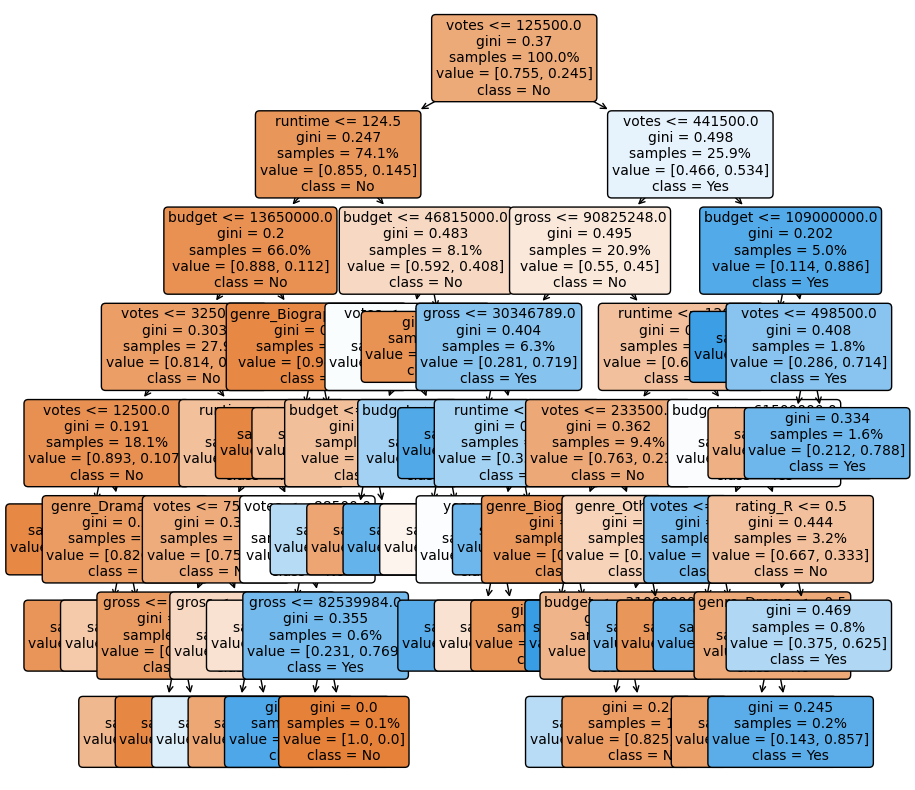

In [40]:
_, ax = plt.subplots(figsize=(10,10))
plot_tree(tree_best,
          feature_names=feature_names,
          class_names=['No', 'Yes'],
          proportion=True,
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax);

### Tree pruning

Finally, we will examine if we can get a smaller tree (simpler model) of roughly equal performance as the previous one, by using a post-pruning technique. Post-pruning consists of removing nodes and branches of a fully grown tree, to avoid having an overfitted model and thus improve the model’s ability to generalize.

Specifically, we will use the [*Minimal cost-complexity pruning*](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning). To understand this algorithm, we first need to understand what this algorithm tries to achieve.

In simple terms, the algorithm tries to find a balance between **cost** and **complexity** of a tree, where *cost* is related to how many errors the tree makes on the data, while *complexity* is determined by the number of "leaves" (terminal nodes) the tree has. A more complex tree might have less error on the training data, but it also has a higher complexity cost. So, there is a need to find a **balance** between *cost* and *complexity*.

The algorithm does through the following steps:

1. Start with the fully grown decision tree.
2. Identify the weakest links: At each step, the algorithm identifies the "weakest" internal node. A node is considered "weakest" if its removal (pruning the subtree below it and turning that node into a leaf) results in the smallest increase in error for the largest decrease in complexity.
3. Prune and repeat: It prunes that weakest node and then repeats the process: find the new weakest link in this smaller tree, prune it, and so on.
4. Use the "cost-complexity" parameter (**alpha**) to control the pruning process. This parameter controls how much you penalize complexity:
- When alpha is small, the algorithm tolerates more complexity (it prefers trees with lower error, even if they are large).
- When alpha is large, the algorithm heavily penalizes complexity (it prefers much simpler trees, even if they have slightly higher error).

To find an optimal value for the cost-complexity parameter (alpha), we need to split our training dataset into training and validation subsets. We will build several trees, using different values of alpha and the training subset, and then find the tree with the best performance on the validation subset. To obtain the candidate alpha values, we will use the [cost_complexity_pruning_path](https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.cost_complexity_pruning_path) method of the DecisionTreeClassifier class.

In [41]:
X_train_sub, X_validate, y_train_sub, y_validate = train_test_split(X_train, 
                                                                    y_train,
                                                                    test_size=0.20,
                                                                    random_state=1,
                                                                    shuffle=True,
                                                                    stratify=y_train)

In [42]:
# Use the cost_complexity_pruning_path method to find candidate alpha values for the previously built tree

path = DecisionTreeClassifier(random_state=1,max_depth=8, min_impurity_decrease=0.001).cost_complexity_pruning_path(X_train_sub, y_train_sub)

In [43]:
path.keys()

dict_keys(['ccp_alphas', 'impurities'])

In [44]:
path['ccp_alphas']

array([0.        , 0.00101043, 0.00101312, 0.00101388, 0.00102993,
       0.00105604, 0.0010699 , 0.00124973, 0.00129723, 0.00132338,
       0.00139775, 0.00142361, 0.00149099, 0.00150266, 0.00153072,
       0.00166549, 0.00168483, 0.00183445, 0.00210773, 0.00246482,
       0.00257413, 0.0027282 , 0.00323269, 0.00355252, 0.00364269,
       0.00405504, 0.00445557, 0.00634449, 0.0124099 , 0.01320073,
       0.01691011, 0.05893687])

In [45]:
# Build and post-prune several trees, one for each candidate alpha value
# Find the model with the best F1 on the validation set

best_f1 = 0
best_ccp_alpha = None

ccp_alphas = path.ccp_alphas[:-1] # do not use the last alpha value as it corresponds to a tree w/ one node only
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=1,max_depth=8, min_impurity_decrease=0.001, ccp_alpha=ccp_alpha)
    dt.fit(X_train_sub, y_train_sub)
    cm = confusion_matrix(y_validate, dt.predict(X_validate))
    f1 = compute_basic_eval_measures(cm)['F1']
    if f1 > best_f1:
        best_f1 = f1
        best_ccp_alpha = ccp_alpha

In [46]:
# Build a new tree using the best alpha value, now using the entire training set

best_pruned = DecisionTreeClassifier(random_state=1, max_depth=8, min_impurity_decrease=0.001, ccp_alpha=best_ccp_alpha)
best_pruned.fit(X_train, y_train)
cm = confusion_matrix(y_test, best_pruned.predict(X_test))
eval3 = compute_basic_eval_measures(cm, "best_pruned")
eval3

accuracy     0.851003
precision    0.753769
recall       0.583658
F1           0.657895
Name: best_pruned, dtype: float64

In [47]:
pd.concat([eval1, eval2, eval3], axis=1)

,tree1,tree_best,best_pruned
accuracy,0.663801,0.855778,0.851003
precision,0.415027,0.767677,0.753769
recall,0.902724,0.591440,0.583658
F1,0.568627,0.668132,0.657895


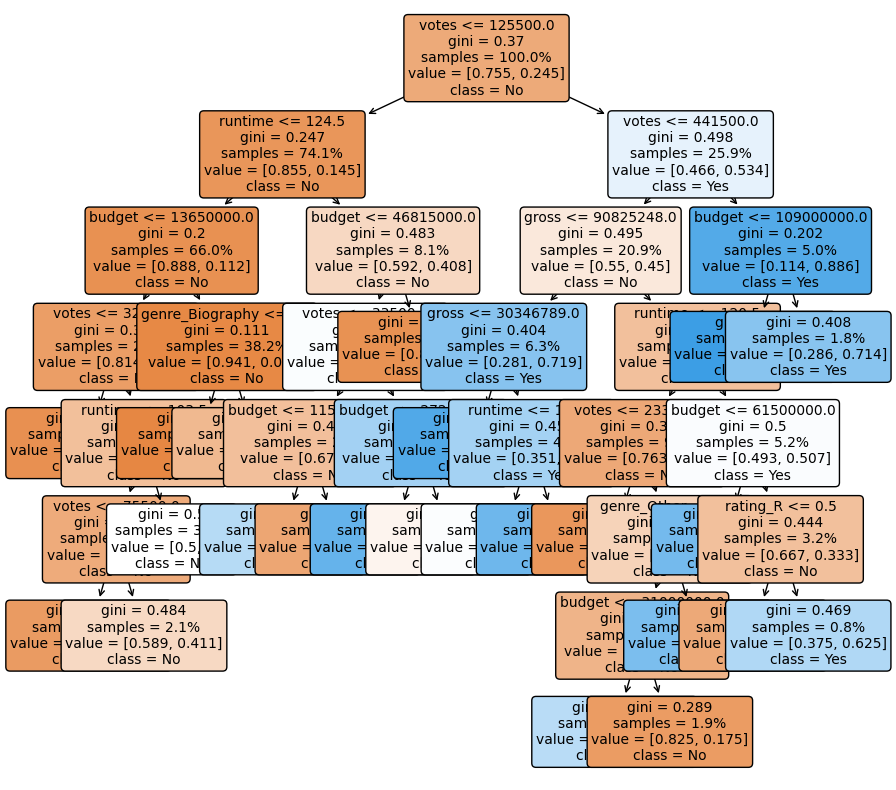

In [48]:
# Plot the 3rd tree

_, ax = plt.subplots(figsize=(10,10))
plot_tree(best_pruned,
          feature_names=feature_names,
          class_names=['No', 'Yes'],
          proportion=True,
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax);

The pruned tree has a slightly lower performance compared to the 2nd model, but is also somewhat simpler, thus less prone to overfitting and better able to generalise. Thus, we keep the pruned model as the best one.   

### Estimate and examine variable importance

A tree model built using the DecisionTreeClassifier class has, as one of its attributes, `feature_importances_` a numpy array of estimated feature importances. Feature importance is computed as the (normalized) total reduction of the applied criterion (e.g., Gini or entropy) brought by that feature.

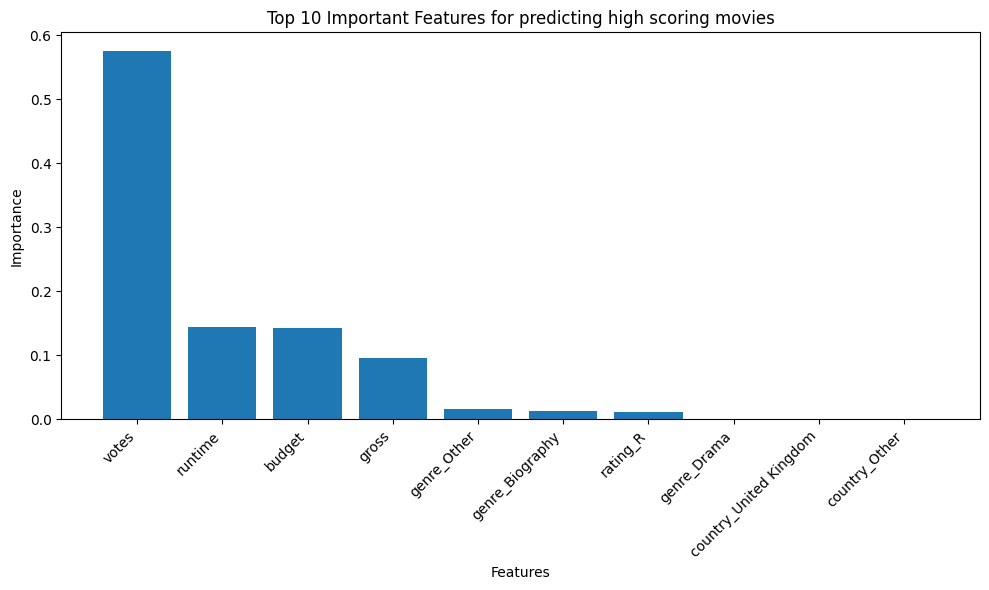

In [49]:
# Get the estimated feature importance

importances = best_pruned.feature_importances_
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
# get the top 10 features with the highest importance
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

# Plot the feature importance
plt.figure(figsize=(10,6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title("Top 10 Important Features for predicting high scoring movies")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()